# Eval of Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

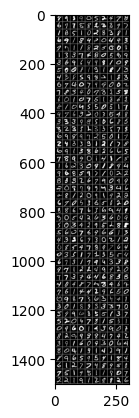

In [2]:
# Folder where the dataset is used
data_set_root = "../data"

# Downloading the mnist (training set)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Selecting randomly 500 examples
number_of_examples = 500
rand_perm = torch.randperm(dataset.data.shape[0])[:number_of_examples]
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1,-1) for i in rand_perm])

out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose(1,2,0))

# Loading the trained model

In [3]:
from vit import VisionTransformer

# Size of the image.
# MNIST has 28x28 handwritten images
image_size = 28

# Patches
patch_size = 7

# Color channels
# MNIST uses grayscale images
in_channels = 1

# For MNIST there will be one class for each single digit
num_classes = 10

# Embedding dimension
embed_dim = 64
depth = 6
num_heads = 8
mlp_ratio = 4.0
dropout = 0.1


# Creating the ViT
model = VisionTransformer(
        image_size=image_size,
        patch_size=patch_size,
        in_channels=in_channels,
        num_classes=num_classes,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        dropout=dropout
    )

# Load
model.load_state_dict(torch.load("../checkpoints/model.pt"))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (projection): Conv2d(1, 64, kernel_size=(7, 7), stride=(7, 7))
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Using the model 

In [23]:
# Gets the evaluation of the dataset to play with 
eval_dataset = dataset_tensor.reshape(-1, 1, 28, 28)
eval_dataset.shape

# Show image
index = 3

# Index the dataset to get the image 
digit_for_eval = eval_dataset[index].unsqueeze(0)

# Requires x shape: (batch_size, channels, height, width)
# Has shape: (channels, height, width)
# Do a single prediction

pred = model(digit_for_eval)
predicted_class = pred.argmax(dim=1).item()
print("Predicted class: ", predicted_class)

# If you want to see the probabilities for all classes:
probabilities = torch.nn.functional.softmax(pred, dim=1)
print("\nProbabilities for each digit:")
for digit, prob in enumerate(probabilities[0]):
    print(f"Digit {digit}: {prob.item():.4f}")



Predicted class:  9
tensor([[3.4136e-05, 1.5363e-05, 3.3806e-05, 8.2976e-05, 8.8721e-05, 6.2262e-05,
         2.1659e-05, 3.6650e-04, 2.2242e-05, 9.9927e-01]],
       grad_fn=<SoftmaxBackward0>)

Probabilities for each digit:
Digit 0: 0.0000
Digit 1: 0.0000
Digit 2: 0.0000
Digit 3: 0.0001
Digit 4: 0.0001
Digit 5: 0.0001
Digit 6: 0.0000
Digit 7: 0.0004
Digit 8: 0.0000
Digit 9: 0.9993


# Function for prediction

In [ ]:
def predict(digit_tensor, model):
    # Add batch dimension to be able to predict a digit 
    digit_for_eval = digit_tensor.unsqueeze(0)

    # Pass the digit to the model 
    pred = model(digit_for_eval)

    # Find the digit with highest probability 
    pred_digit = pred.argmax(dim=1).item()

    # If you want to see the probabilities for all classes:
    probabilities = torch.nn.functional.softmax(pred, dim=1)
    probabilities_dict = {}
    for digit, prob in enumerate(probabilities[0]):
        probabilities_dict.update({digit: prob.item()})

    return pred_digit, probabilities_dict 


def print_pred(digit, prob):
    print("Predicted digit: ", digit)
    for d, p in prob.items():
        print(f"Digit {d}: {p:.4f}")
    


index = 34
digit, prob = predict(eval_dataset[index], model)
print_pred(digit, prob)



Predicted digit:  4
Digit 0: 0.0000
Digit 1: 0.0000
Digit 2: 0.0000
Digit 3: 0.0000
Digit 4: 0.9992
Digit 5: 0.0000
Digit 6: 0.0004
Digit 7: 0.0001
Digit 8: 0.0000
Digit 9: 0.0002


## Testing with custom display function

In [46]:
# Helper function
def predict_and_display(digit_tensor, model):
    plt.imshow(digit_tensor.reshape(28,28).numpy(), cmap="gray")
    digit, prob = predict(digit_tensor, model)
    print_pred(digit, prob)

Predicted digit:  6
Digit 0: 0.0035
Digit 1: 0.0003
Digit 2: 0.0000
Digit 3: 0.0002
Digit 4: 0.0001
Digit 5: 0.2965
Digit 6: 0.6990
Digit 7: 0.0001
Digit 8: 0.0001
Digit 9: 0.0002


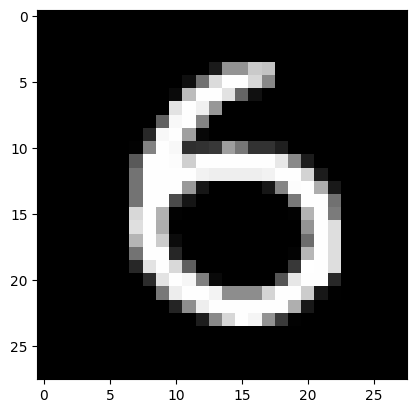

In [49]:
# Change the index to test different images
index = 90
assert index < 500
predict_and_display(eval_dataset[index], model)